In [3]:
import cv2
import pandas as pd
from scipy import ndarray
from matplotlib import pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import random
import skimage as sk
from PIL import Image
import uuid

path = "Datasets/HQ_digital"
csv = "Datasets/HQ_quality"
data = pd.read_csv(csv +'.csv', sep=';', index_col=0)

# PREPROCESSING FUNCTIONS

In [4]:
#Run this function first
def preprocess_and_find_display(image):
    
    image = imutils.resize(image.copy(), height=500)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(gray,127,255,1)
    a,cnts,h = cv2.findContours(thresh,1,2)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None

    for cnt in cnts:
        approx = cv2.approxPolyDP(cnt,0.01*cv2.arcLength(cnt,True),True)
        if len(approx)==4 and cv2.contourArea(approx) > 100*200 :
            displayCnt = approx

            break
    warped = four_point_transform(gray, displayCnt.reshape(4, 2))
    output = four_point_transform(image, displayCnt.reshape(4, 2))
    plt.imshow(warped,cmap = 'gray')
    plt.show()
    
    return warped, output

In [12]:
def crop_digits(image):
    digits = []
    image_width = image.shape[1]
    cropped = image[10:160, 10:(round((3/5)*image_width))]
    width = cropped.shape[1]
    w_1 = cropped[:, -round(width/4):]
    w_2 = cropped[:, -2*round(width/4):-round(width/4):]
    w_3 = cropped[:, -3*round(width/4):-2*round(width/4):]
    w_4 = cropped[:, :-3*round(width/4):]
    digits.append(w_1)
    digits.append(w_2)
    digits.append(w_3)
    digits.append(w_4)
    return digits

def suppress_black_contour(image, th_pix_blanc):
    h, w = image.shape
    nb_pix_rect = 0 # left crop
    x = 0
    while nb_pix_rect <th_pix_blanc:
        left_rect = image[:,:x]
        nb_pix_rect = np.sum(left_rect == 255)
        x += 1
    img = image[:, x +1 :]
    nb_pix_rect = 0 # right crop
    x = 0
    while nb_pix_rect <th_pix_blanc:
        right_rect = image[:,w-x:]
        nb_pix_rect = np.sum(right_rect == 255)
        x += 1
    img = img[:, :w-x +1]
    nb_pix_rect = 0  # top crop
    x = 0
    while nb_pix_rect <th_pix_blanc/3:
        top_rect = image[h-x +1:,:]
        nb_pix_rect = np.sum(top_rect == 255)
        x += 1
    img = img[:h-x, :]
    nb_pix_rect = 0 # bottom crop
    x = 0
    while nb_pix_rect <th_pix_blanc/3:
        bot_rect = image[:x,:]
        nb_pix_rect = np.sum(bot_rect == 255)
        x += 1
    img = img[x+1:, :]
    return img

def clean_digits(digits, th_pix_blanc_tot, th_pix_blanc_sup):
    digits_clean = []
    stop = 0
    nb_digits = 0
    for i in range(4):
        image = digits[i]
        plt.imshow(image,cmap = "gray")
        plt.show()
        blurred = cv2.bilateralFilter(image, 10, 10, 100)
        thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 17, 2)
        inv = cv2.bitwise_not(thresh)
        kernel = np.ones((7,7), np.uint8)
        closing = cv2.morphologyEx(inv, cv2.MORPH_CLOSE, kernel)
        dilatation = cv2.dilate(closing, np.ones((3,3), np.uint8), iterations = 2)
        plt.imshow(dilatation, cmap = "gray")
        k = np.sum(dilatation == 255)
        plt.imshow(dilatation,cmap = "gray")
        plt.show()
        print(k)
        if k > th_pix_blanc_tot and stop == 0:
            im2 = suppress_black_contour(dilatation, th_pix_blanc_sup)
            h, w = im2.shape
            if h> 80 and w >25: # pour ne pas garder les petits coins d'images tout blancs
                im3 = cv2.resize(im2, (80,50)).flatten()
                digits_clean.append(im3)
                plt.imshow(im2,cmap = "gray")
                plt.show()
                nb_digits +=1
            else:
                stop = 1
        digits_clean = digits_clean[::-1]
    return digits_clean, nb_digits

In [13]:
#### TOTAL PREPROCESSING PIPELINE ######

def digits_clean_loc(i, h_noise, h_2, lowThreshold, t, t_2):
    image = cv2.imread(path + '/' + data.loc[i, 'image'])
    image_name = data.loc[i, 'image']
    # pre-process the image
    warped, output = preprocess_and_find_display(image)
    digits = crop_digits(warped)
    digits_clean, n = clean_digits(digits, th_pix_blanc_tot, th_pix_blanc_sup)    
    return (image_name, digits_clean)

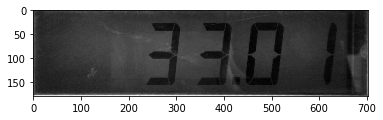

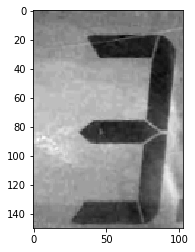

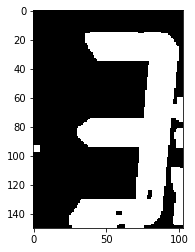

5438


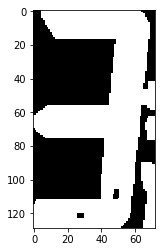

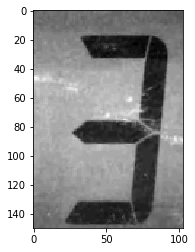

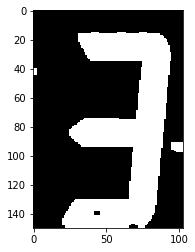

5030


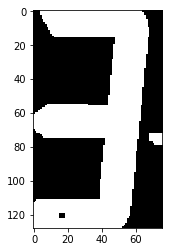

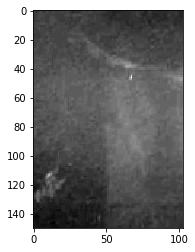

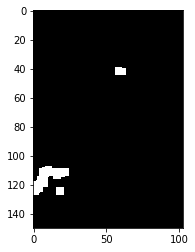

300


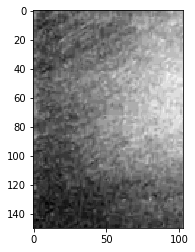

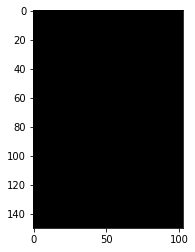

0


('e104664ba1792dde641d87cd5d95f1df06786140.jpg',
 [array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
  array([  0,   0,   0, ..., 255, 255, 255], dtype=uint8)])

In [15]:
i = 0
h_noise = 10 # noise coefficient
h_2 = 15
lowThreshold = 50 # canny edge detection
t = 150 # threshold to separate white/black
t_2 = 150
th_pix_blanc_tot = 150
th_pix_blanc_sup = 60


digits_clean_loc(i,10,15,50,150,150)

# PREPROCESSING

0


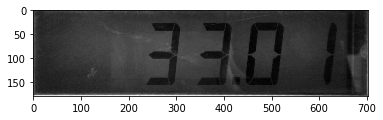

5438
5030
300
0
1


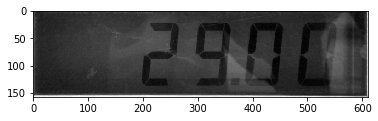

6083
5034
1388
1146
2


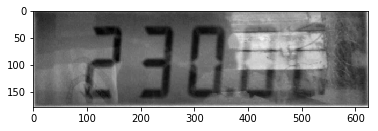

5919
3940
4237
986
3


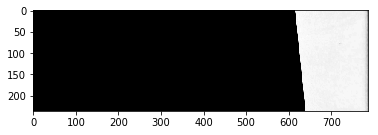

0
0
0
0
4
5


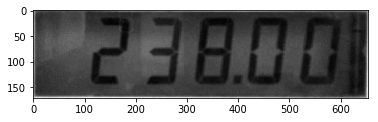

5730
4285
4325
160
6
7


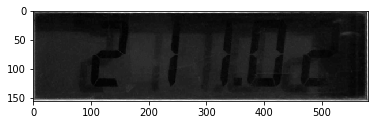

2655
2866
3769
1059
8


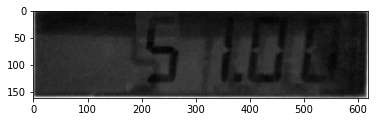

2105
3689
1025
1031
9


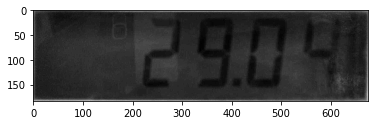

3738
3638
90
45
10
11


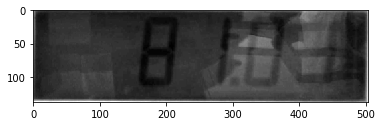

2305
3991
1051
907
12


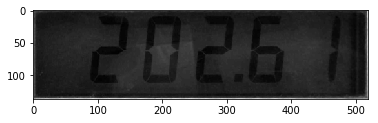

3507
4348
3610
836
13


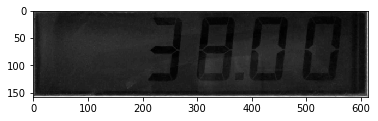

5803
5031
1147
1337
14


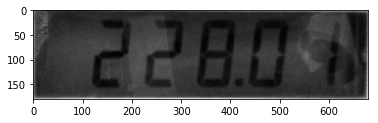

4380
3985
4227
958
15


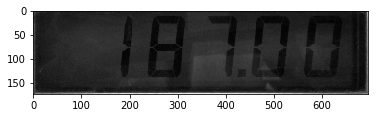

2713
6474
2417
0
16


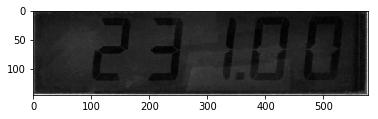

2264
4244
4269
970
17


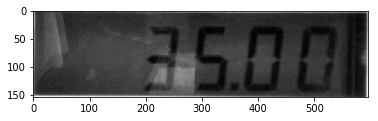

4844
4589
1035
2236
18


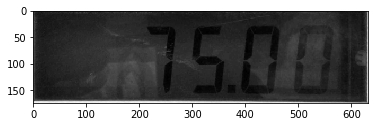

4458
3436
920
0
19


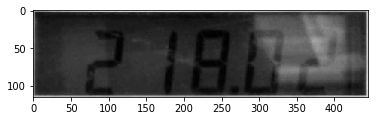

3335
1684
2193
864
20
21


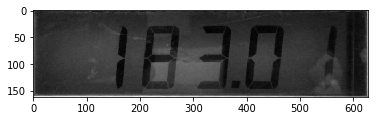

5272
7075
3246
1032
22
23


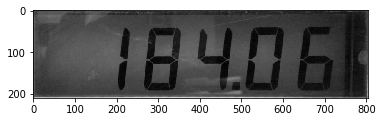

5330
7094
3086
1209
24


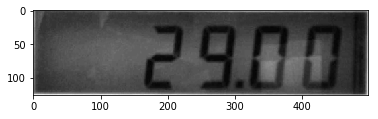

3786
3405
902
959
25


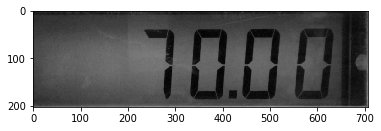

5344
3252
75
0
26


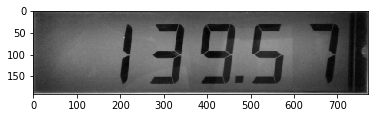

6101
5019
2585
0
27


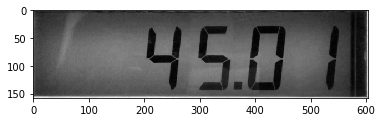

4997
4566
1121
1848
28


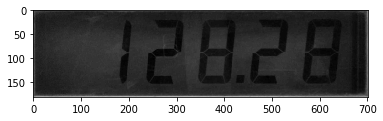

6157
4807
2569
0
29


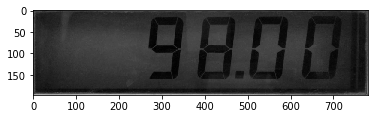

7637
6699
0
375
30
31


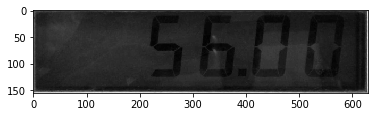

5382
4876
1301
1258
32


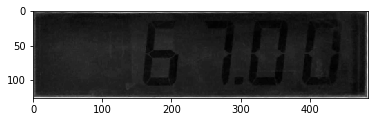

1995
3510
758
797
33


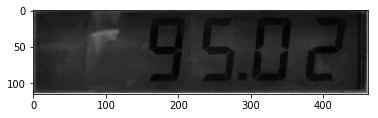

2775
3216
1696
717
34


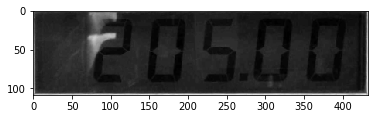

2389
2932
3723
1028
35


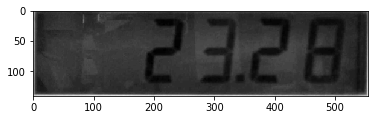

3521
4029
1416
1349
36


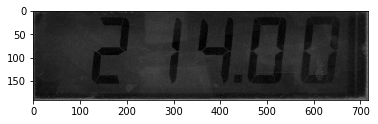

4762
2674
5226
76
37


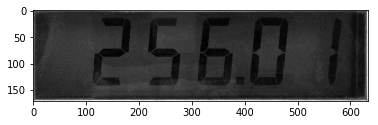

5364
4384
4460
461
38


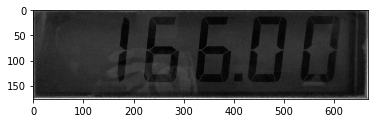

6131
6244
3232
249
39


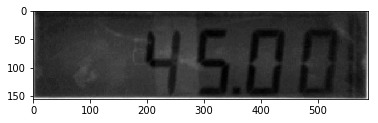

4093
4055
1033
1047
40


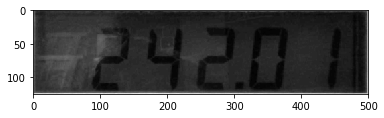

2980
3120
3275
2027
41


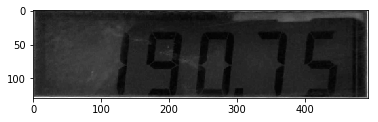

3507
3590
2297
811
42


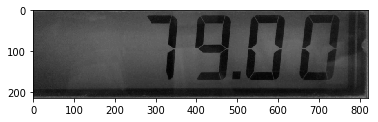

7311
4321
20
0
43


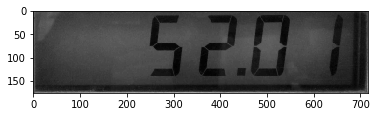

4964
5415
378
582
44


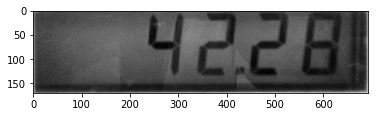

4465
4773
662
159
45


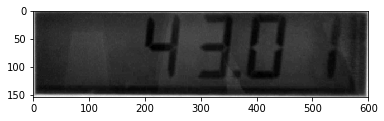

4315
4302
1388
1289
46


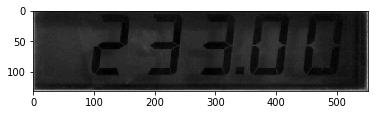

3602
3986
3706
1077
47


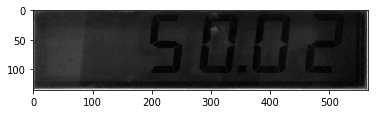

4269
3978
1306
1230
48


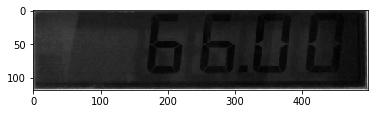

3176
3522
936
1041
49


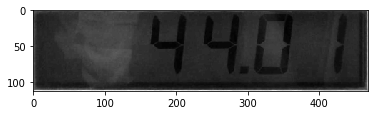

2504
2851
1217
956
50


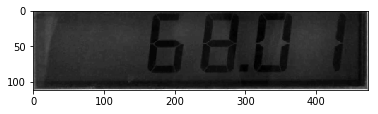

3368
3580
994
1234
51


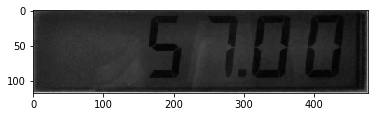

1899
3035
733
759
52


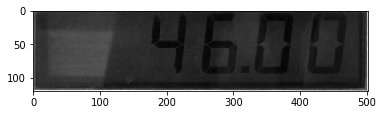

3445
3000
1443
943
53


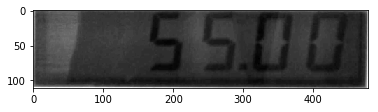

2522
2855
957
1520
54


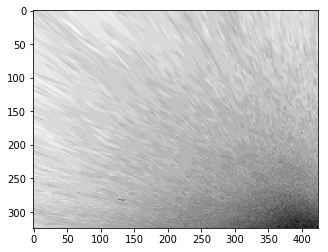

0
0
0
0
55


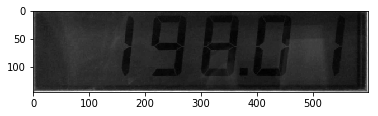

4728
4659
2898
1094
56


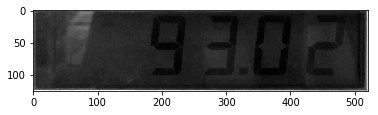

2549
3369
1151
1577
57


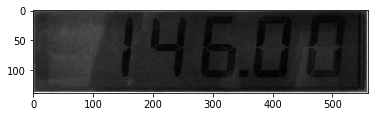

3778
3639
2665
992
58


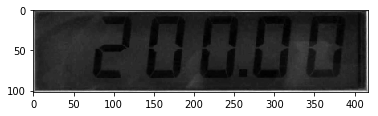

2432
2748
2396
624
59


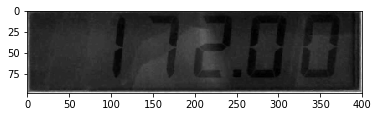

2120
1532
1480
571
60


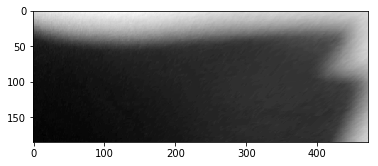

450
597
694
960
61


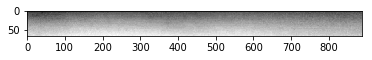

0
0
0
20
62


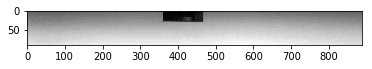

1133
555
0
0
63


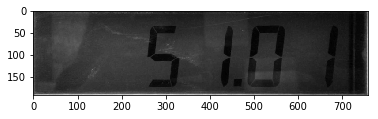

2751
4811
533
595
64


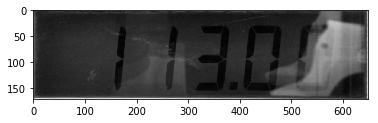

4885
2666
2294
0
65


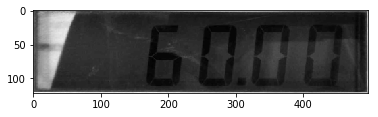

3720
3822
871
3454
66


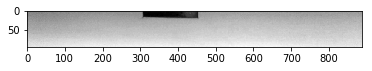

578
935
0
0
67


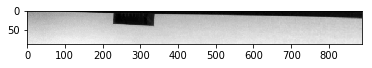

276
1088
703
0
68


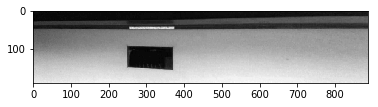

3546
6486
4318
3054
69


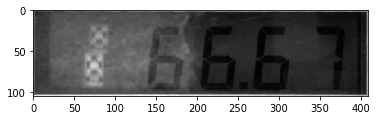

3240
3121
2867
1888
70


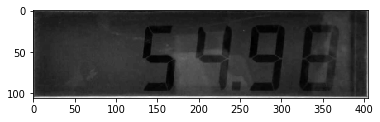

2712
2602
721
755
71


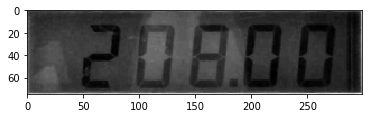

1892
1769
1395
739
72
73


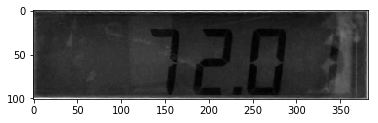

2182
1735
616
601
74


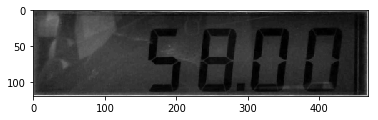

3828
3001
1330
3025
75


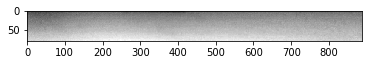

0
0
0
0
76


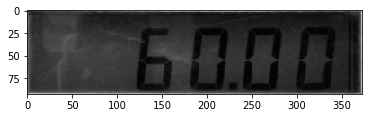

2359
2278
573
993
77


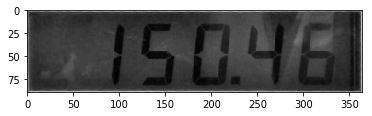

2266
2026
1394
892
78


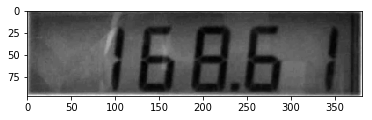

2710
2465
1921
708
79
80


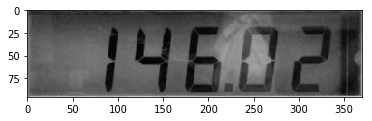

2577
2085
1381
609
81


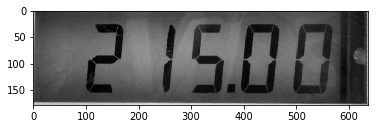

5298
2284
4482
93
82


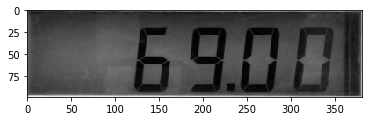

2618
2535
762
633
83
84


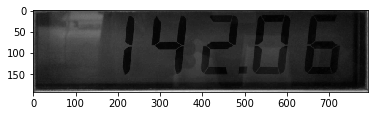

5210
4617
3716
1835
85


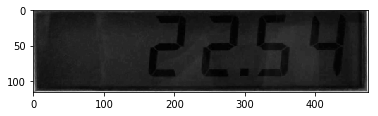

2530
2757
725
773
86


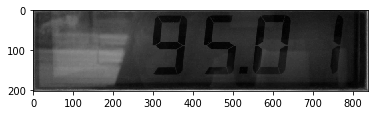

5190
6029
4408
4957
87


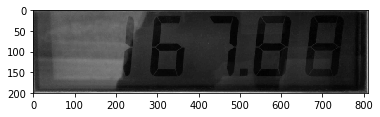

2341
6771
3867
2349
88


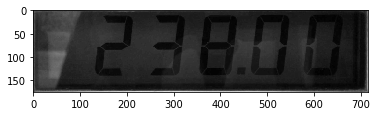

6090
4937
5023
3330
89


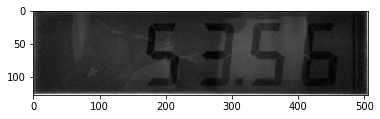

3743
3653
912
879
90


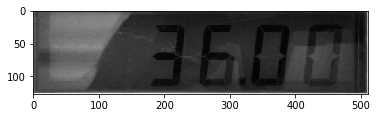

4053
3642
2314
1743
91


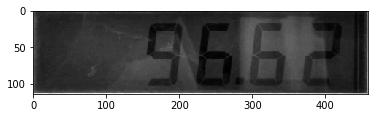

3790
3710
800
826
92


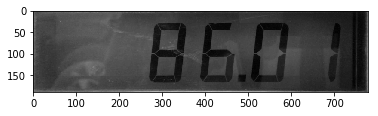

6546
7237
1496
1249
93


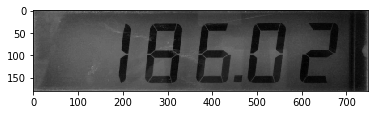

6114
7329
3051
536
94


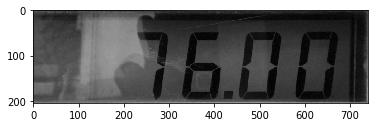

5619
6468
2481
4246
95
96


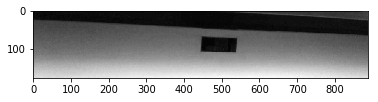

3485
1261
1235
1200
97
98


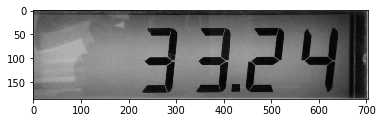

4790
4730
1107
3327
99


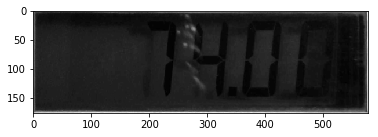

5694
2593
0
0
100


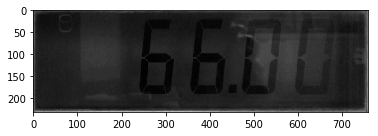

4676
4734
0
561
101


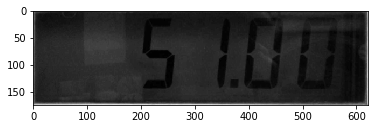

2282
4103
0
25
102


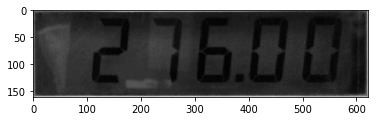

5315
3808
4959
1414
103


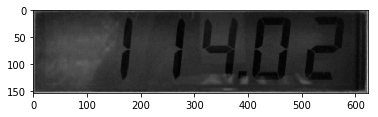

4684
2797
2989
1100
104


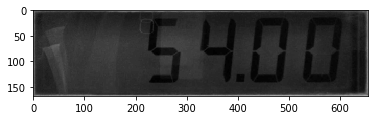

3630
4595
0
1781
105


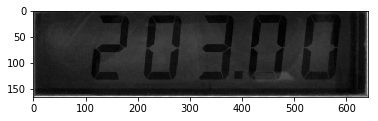

4473
5590
4410
557
106


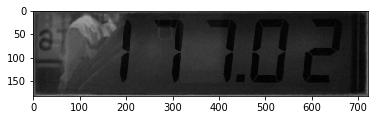

2707
3436
6019
5771
107


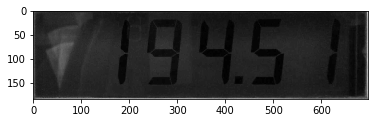

4042
5424
2313
3074
108


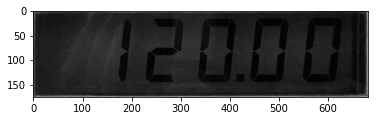

5169
4637
2348
25
109


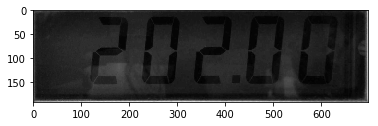

4557
6050
5493
25
110


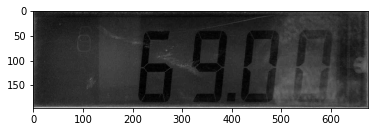

5151
4918
693
42
111


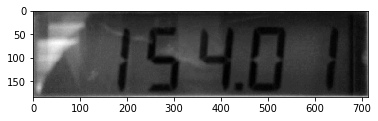

3817
3731
2244
4371
112


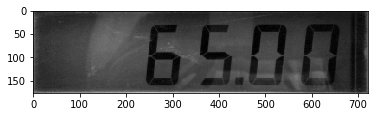

5450
5944
623
25
113


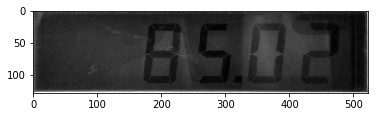

3905
4980
982
1040
114


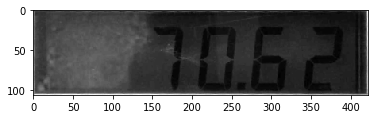

2822
2015
990
1369
115


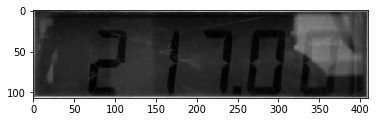

1904
1610
2322
1719
116


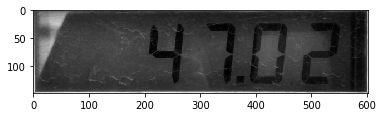

3436
4451
2147
3790
117


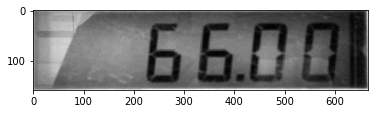

6217
6206
1995
4233
118


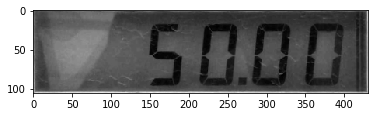

3003
2734
1611
1564
119


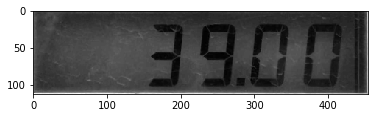

3366
3032
923
1085
120


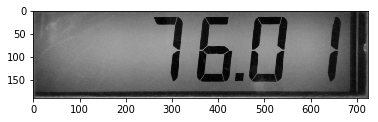

6524
3575
50
997
121


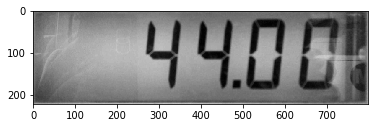

5222
5208
0
2592
122


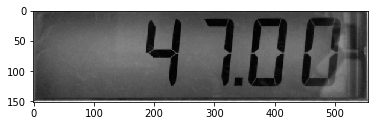

3159
4009
805
1072
123


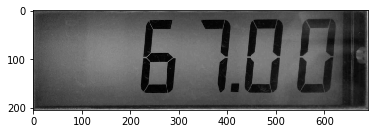

3627
5852
35
0
124


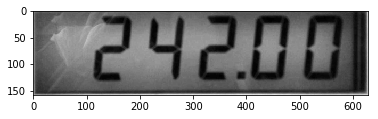

4836
4611
5647
2699
125


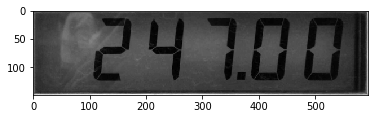

3075
4286
5327
2275
126


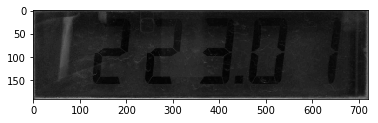

3436
4162
4022
3326
127


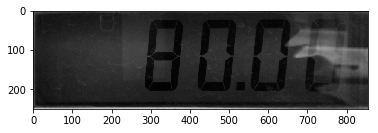

5177
6965
505
0
128


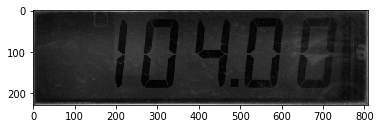

5277
5979
2853
0
129


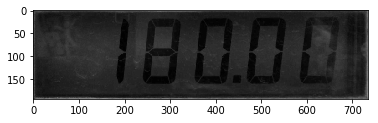

6238
6997
2749
1176
130


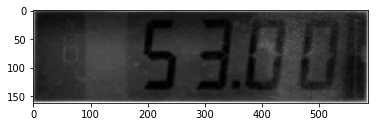

4193
4241
834
900
131


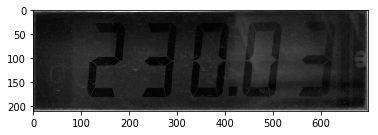

4381
3442
3779
0
132


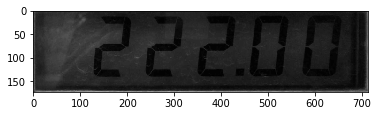

4206
4931
5181
1743
133


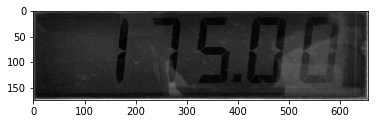

4972
4166
2276
139
134


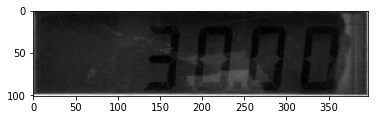

2992
2218
648
645
135


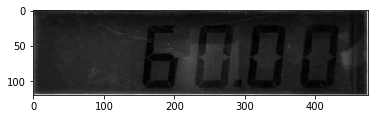

3690
3564
802
743
136


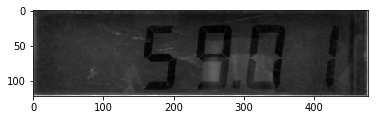

4065
3282
896
750
137


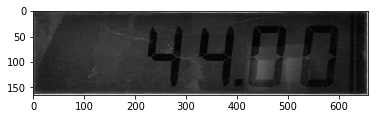

4325
4052
747
1003
138


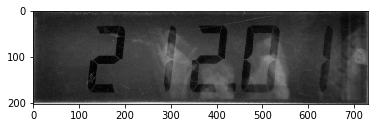

5348
3942
4584
0
139


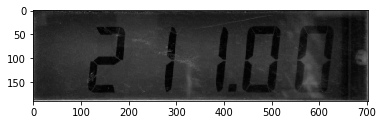

3190
2625
4423
104
140


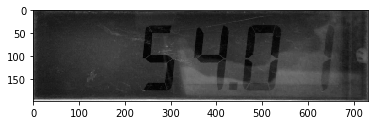

5462
5346
749
0
141


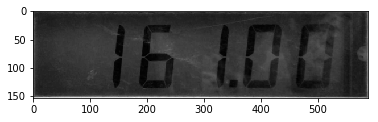

3664
5605
3168
1039
142


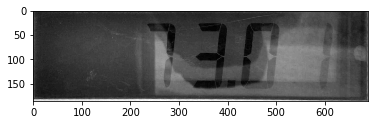

6088
5785
135
0
143


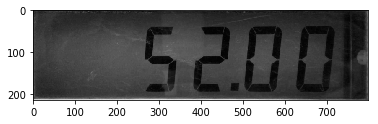

4737
4803
196
0
144


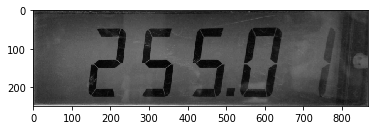

4809
4924
5082
117
145


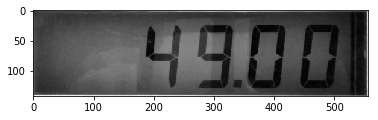

5627
4239
1002
936
146


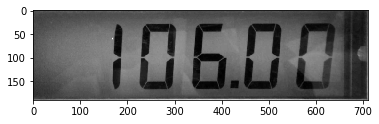

6122
6534
2667
25
147


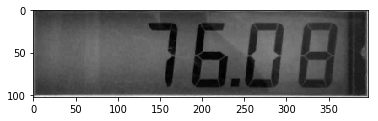

3032
1951
786
663
148


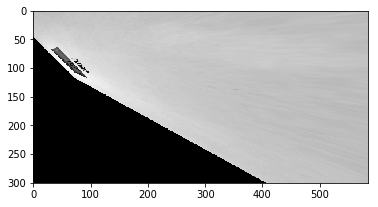

0
30
659
2908
149


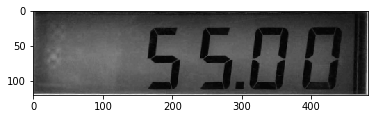

3161
3162
796
1292
150


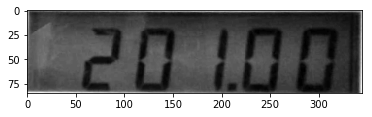

1054
2037
1615
853
151


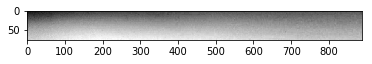

48
224
98
323
152


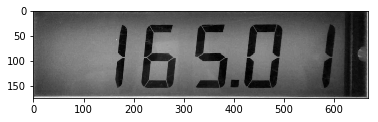

4748
5434
2235
0
153
154


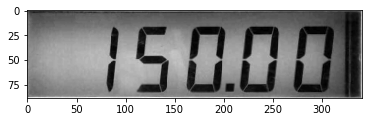

2323
1970
1357
687
155


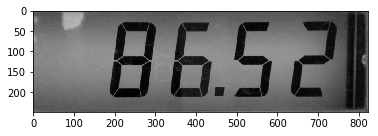

3582
6896
4461
1696
156
157


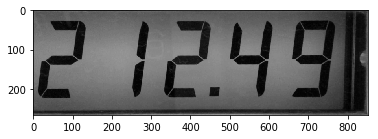

4859
4924
124
6332
158


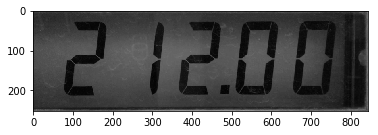

5501
3321
3571
2378
159


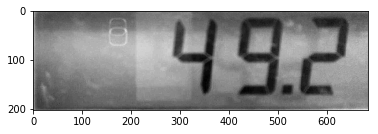

3942
1791
1424
305
160


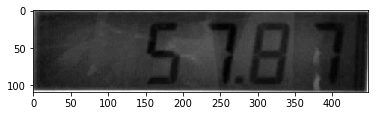

2031
2792
764
781
161


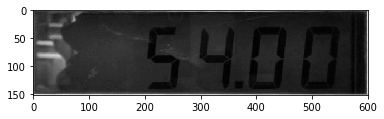

4390
4603
1215
6388
162


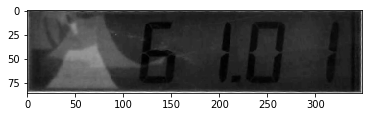

1083
2336
1808
2257
163


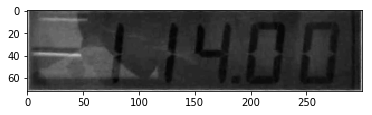

1261
1098
1428
1657
164


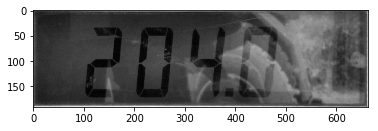

6633
5517
4930
196
165


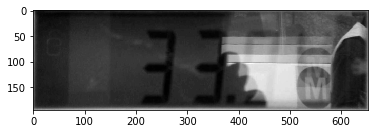

4305
3457
70
95
166


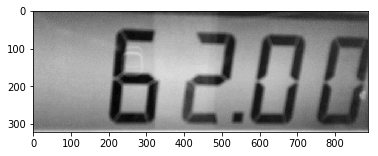

4894
2063
3725
0
167
168
169
170


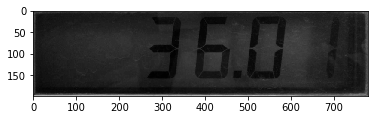

6591
5402
0
0
171


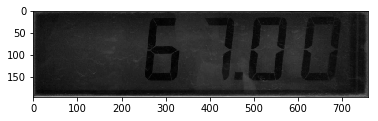

3351
6509
25
0
172


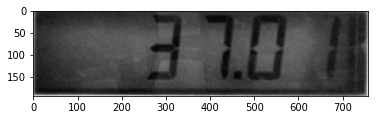

3002
4854
0
0
173


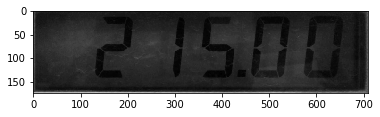

4713
2239
4854
67
174


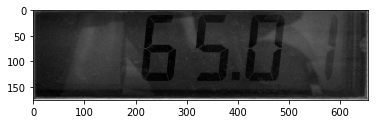

5229
5841
1724
416
175


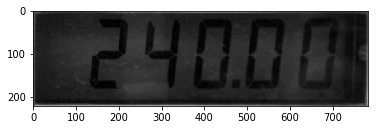

5715
5239
4677
0
176


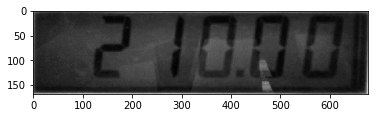

4321
2468
3998
30
177


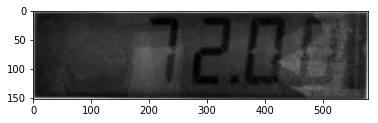

4007
3070
1076
1044
178


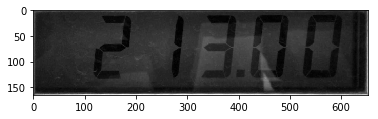

5071
3003
4471
377
179


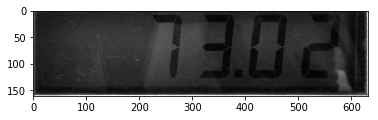

5243
4059
1448
1471
180


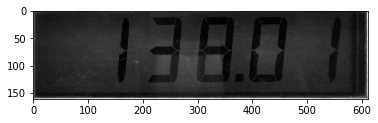

6786
5211
3088
1066
181


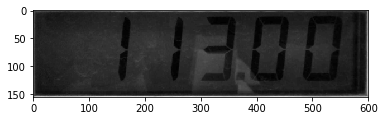

4630
3011
3018
1080
182


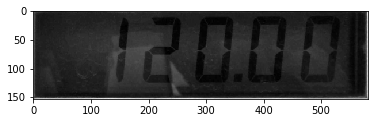

5739
6038
3048
1194
183


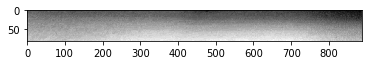

0
0
0
0
184


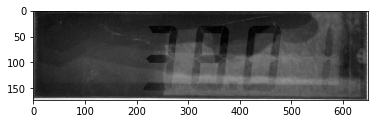

6563
4750
69
0
185


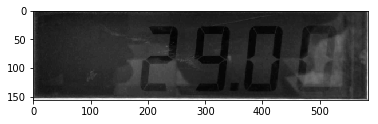

5940
5561
2022
1202
186


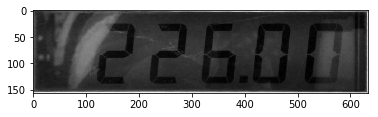

5825
4882
6835
6443
187


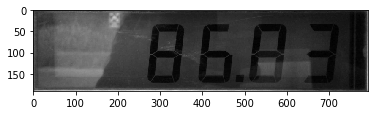

6103
7486
3427
3952
188


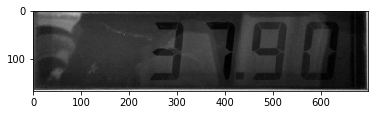

2695
4362
105
3611
189


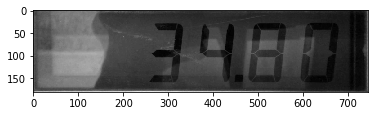

5108
5144
2906
3368
190


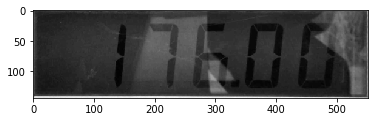

6019
4158
2707
1089
191


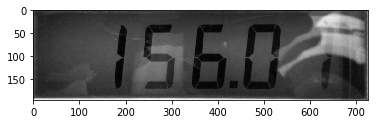

5888
5858
2823
65
192


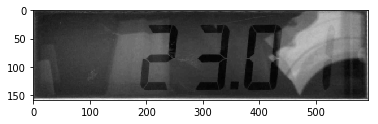

5147
5666
1953
1733
193


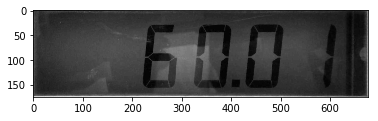

6901
6232
465
146
194


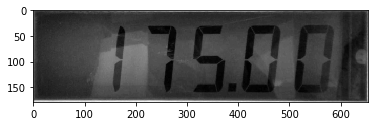

4523
4251
3492
0
195


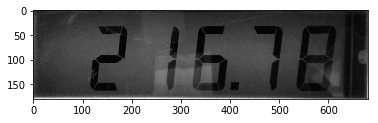

6101
3177
4430
153
196


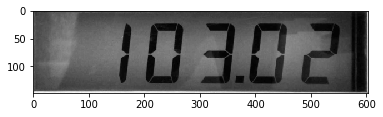

4718
5744
2974
2147
197


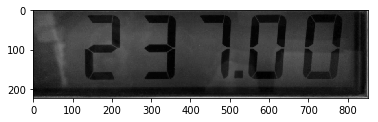

4116
5723
5101
2168
198


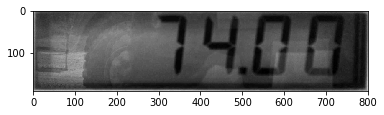

4331
2752
339
4663
199
200


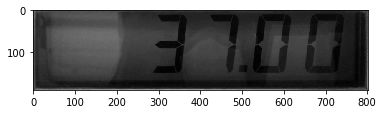

2420
4960
1196
1821
201
202
203


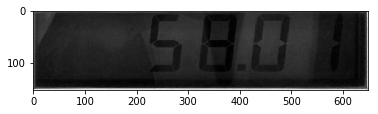

5010
4843
1432
1772
204


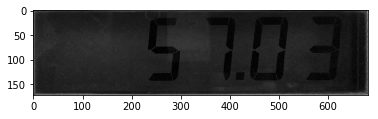

2332
4506
0
0
205


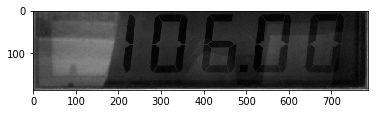

5785
5481
5439
3575
206


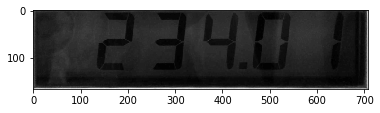

3097
3564
4226
561
207


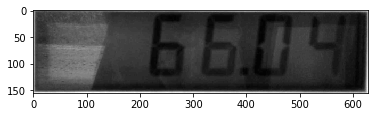

3587
4776
2844
3173
208


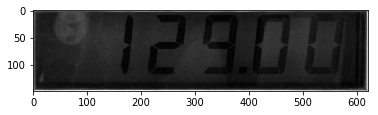

4289
4446
3250
2486
209


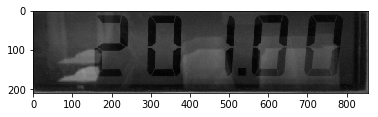

3583
7057
6511
2278
210


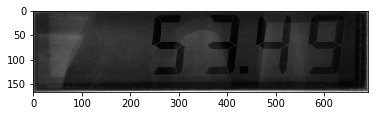

3693
4817
669
1941
211


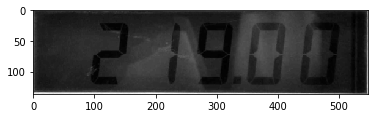

5411
2800
4152
1022
212


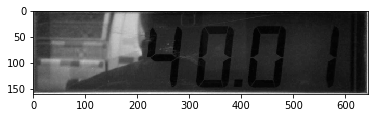

6433
6786
7204
6875
213


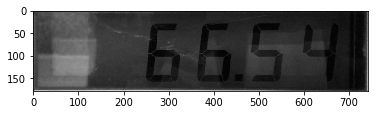

5985
6504
2465
3727
214


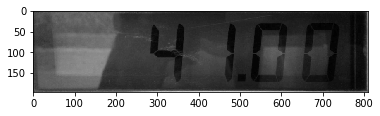

2441
5303
2710
3002
215


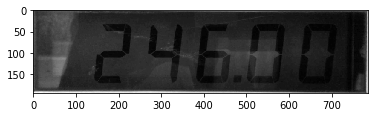

5550
4818
4757
3062
216


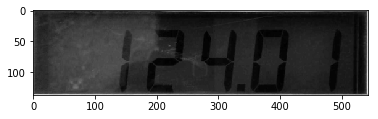

3617
4209
2680
1716
217


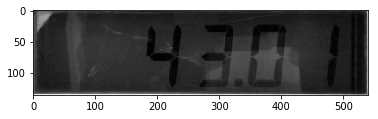

4242
3818
1159
2689
218


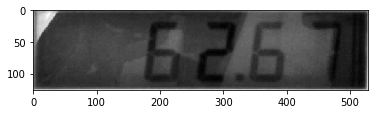

3500
4141
884
1421
219


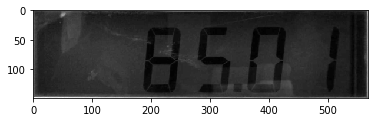

4364
5816
1250
1981
220


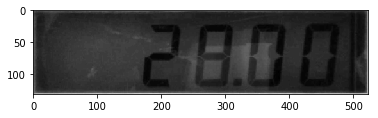

5221
3751
870
925
221


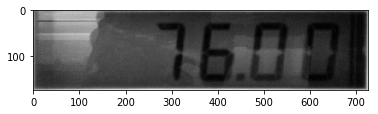

5081
2803
1427
2713
222


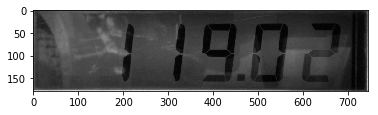

5687
3028
7120
3119
223


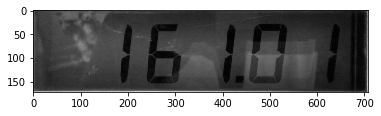

2881
5870
4004
3248
224


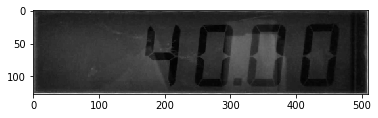

4452
3547
823
819
225


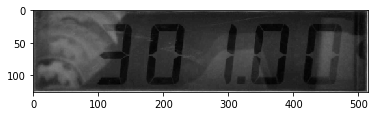

2297
4361
5167
4272
226


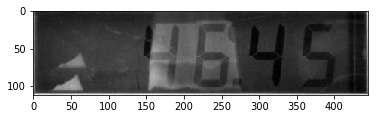

4163
3963
894
2260
227


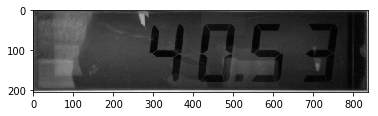

5420
5892
375
4040
228


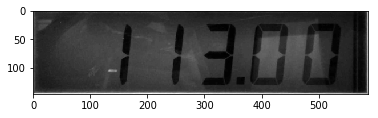

4598
3104
3509
1840
229


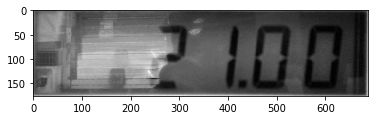

2713
6744
5764
7408
230


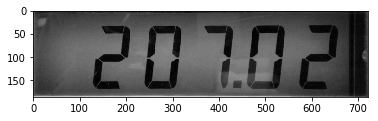

3527
5877
4851
662
231


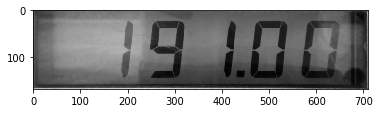

2579
7207
3414
2153
232


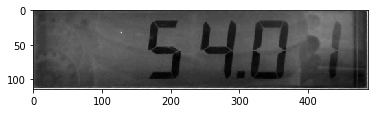

2924
3279
899
1522
233


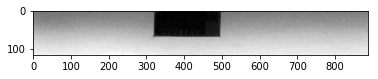

1725
1633
0
0
234


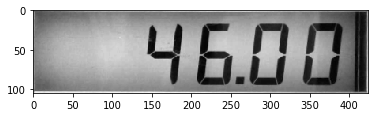

3122
2612
823
984
235
236


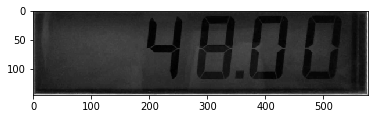

5723
4272
1082
1555
237


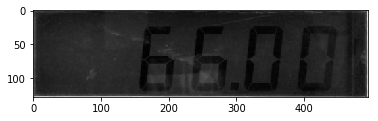

4107
4008
795
766
238


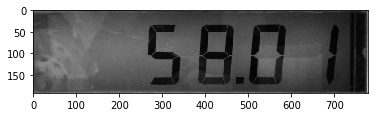

7171
4816
658
3670
239
240


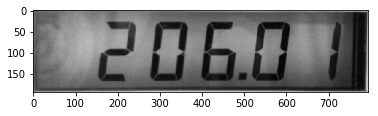

6323
6057
5316
803
241


image  \
0  e104664ba1792dde641d87cd5d95f1df06786140.jpg   
1  48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg   
2  9e111802446b62b86aeffe911415ad28227caba7.jpg   
3  f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg   
4  c836ea17748e562c99f93edc51f2b900664ec37d.jpg   

                                      flatten_arrays  
0  [[0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 25...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...  
3                                                 []  
4  [[0, 0, 0, 0, 68, 255, 255, 255, 255, 255, 255...

In [122]:
###### PARAMETERS TO FIND #######
i = 1
h_noise = 10 # noise coefficient
h_2 = 15
lowThreshold = 50 # canny edge detection
t = 150 # threshold to separate white/black
t_2 = 150
th_pix_blanc_tot = 150
th_pix_blanc_sup = 60

#################################

clean_list_images = []
for i in range(0, data.shape[0]):
    print(i)
    try:
        clean_list_images.append(digits_clean_loc(i,10,15,50,150,150))
    except AttributeError:
        pass
len(clean_list_images)

# dataframe with name and list of arrays for the digits
prediction_data = pd.DataFrame(clean_list_images, columns = ['image', 'flatten_arrays'])
prediction_data.head()



# Getting the labels

In [123]:
def new_labels(old_label):
    number_str = str(old_label)
    if len(number_str) == 1:
        return '   ' + number_str
    if len(number_str) == 2:
        return '  ' + number_str
    if len(number_str) == 3:
        return ' ' + number_str
    if len(number_str) == 4:
        return number_str
    
#define new column for the labels, where each of the label is a string of length 4
data['used_liter2'] = data['used_liter'].apply(lambda x: new_labels(x))
full_data = pd.merge(data, prediction_data, on= 'image').copy()
full_data.head()

used_liter                                         image used_liter2  \
0          33  e104664ba1792dde641d87cd5d95f1df06786140.jpg          33   
1          29  48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg          29   
2         230  9e111802446b62b86aeffe911415ad28227caba7.jpg         230   
3          43  f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg          43   
4         238  c836ea17748e562c99f93edc51f2b900664ec37d.jpg         238   

                                      flatten_arrays  
0  [[0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 25...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...  
3                                                 []  
4  [[0, 0, 0, 0, 68, 255, 255, 255, 255, 255, 255...

# For the flatten arrays

In [124]:
full_data['n_digits'] = [len(i) for i in full_data.flatten_arrays]
full_data.head()

used_liter                                         image used_liter2  \
0          33  e104664ba1792dde641d87cd5d95f1df06786140.jpg          33   
1          29  48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg          29   
2         230  9e111802446b62b86aeffe911415ad28227caba7.jpg         230   
3          43  f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg          43   
4         238  c836ea17748e562c99f93edc51f2b900664ec37d.jpg         238   

                                      flatten_arrays  n_digits  
0  [[0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 25...         2  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         3  
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...         3  
3                                                 []         0  
4  [[0, 0, 0, 0, 68, 255, 255, 255, 255, 255, 255...         3

In [125]:
def true_digit_numbers(string_column, digits_column): 
    new_column = string_column[(4-digits_column):]
    return new_column 

full_data['used_liter3'] = [true_digit_numbers(x,y) for x,y in zip(full_data['used_liter2'], full_data['n_digits'])]
full_data.head()

used_liter                                         image used_liter2  \
0          33  e104664ba1792dde641d87cd5d95f1df06786140.jpg          33   
1          29  48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg          29   
2         230  9e111802446b62b86aeffe911415ad28227caba7.jpg         230   
3          43  f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg          43   
4         238  c836ea17748e562c99f93edc51f2b900664ec37d.jpg         238   

                                      flatten_arrays  n_digits used_liter3  
0  [[0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 25...         2          33  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         3          29  
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...         3         230  
3                                                 []         0              
4  [[0, 0, 0, 0, 68, 255, 255, 255, 255, 255, 255...         3         238

In [126]:
digit_data = full_data[['used_liter3','flatten_arrays']]
digit_label = [small_number for big_number in digit_data['used_liter3'] for small_number in big_number]
digit_array = [array for list_of_arrays in digit_data['flatten_arrays'] for array in list_of_arrays]

In [127]:
digit_result = pd.DataFrame(
    {'label': digit_label,
     'array': digit_array
    })

digit_result.head()

array label
0  [0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 255...     3
1  [0, 0, 0, 0, 0, 115, 255, 255, 255, 255, 255, ...     3
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...      
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     2
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     9

# PREDICTION PART

## Data Augmentation

## KNN Image recognition

In [173]:
labels = []
pixels = []

for l in range(0,10):
    training_dir = 'Digits/' + str(l) + '/'
    for filename in os.listdir(training_dir):
        if (filename.endswith('.jpg')):
            training_digit_image = cv2.imread(training_dir + filename)
            training_digit = cv2.cvtColor(training_digit_image, cv2.COLOR_BGR2GRAY)
            inv_image = cv2.threshold(training_digit, 150, 255, cv2.THRESH_BINARY_INV)[1]
            resized_image = cv2.resize(inv_image, (80,50)).flatten()
            pixels.append(np.array(resized_image))    
            labels.append(l)

# we add to the training set some cropped digits labelled by hand, coming from the images
for l in range(0,10):
    training_dir = 'Digits_by_hand/' + str(l) + '/'
    for filename in os.listdir(training_dir):
        if (filename.endswith('.jpg')):
            training_digit_image = cv2.imread(training_dir + filename)
            training_digit = cv2.cvtColor(training_digit_image, cv2.COLOR_BGR2GRAY)            
            resized_image = cv2.resize(training_digit, (80,50)).flatten()
            pixels.append(np.array(resized_image))    
            labels.append(l)
                    

# store features array into a numpy array
features  = np.array(pixels, 'float64')
# split the labled dataset into training / test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.25)
# train using K-NN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# get the model accuracy
model_score_knn = knn.score(X_test, y_test)
print(' Validation score of the model: ', model_score_knn)

 Validation score of the model:  0.9516129032258065


# Prediction on each image

In [150]:
def knn_prediction(full_image):
    test = np.array(full_image, 'float64')
    try: 
        y = knn.predict(test)
        y_string = [str(x) for x in y]
        final_y = int(''.join(y_string))
    except ValueError:
        y = 'ValueError'
        final_y = -1
    return final_y  

full_data['prediction'] = [knn_prediction(list_of_arrays) for list_of_arrays in full_data['flatten_arrays']]
full_data.head()

used_liter                                         image used_liter2  \
0          33  e104664ba1792dde641d87cd5d95f1df06786140.jpg          33   
1          29  48990b5cbe173868040bd33f06fb1b80c2b4f28a.jpg          29   
2         230  9e111802446b62b86aeffe911415ad28227caba7.jpg         230   
3          43  f78fe5a461f28bc770a7dd856878bb4a314a9027.jpg          43   
4         238  c836ea17748e562c99f93edc51f2b900664ec37d.jpg         238   

                                      flatten_arrays  n_digits used_liter3  \
0  [[0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 25...         2          33   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         3          29   
2  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...         3         230   
3                                                 []         0               
4  [[0, 0, 0, 0, 68, 255, 255, 255, 255, 255, 255...         3         238   

   prediction  
0          33  
1         241  
2         312  
3          -1  
4         382

In [184]:
print('Ratio of images for which we could not detect any digits:', sum(full_data.prediction == -1) / full_data.shape[0])
print('Number of images for which we found digits:', sum(full_data.prediction != -1))

# We detected 220 screen rectangles out of 240 but some of them were corrupted

Ratio of images for which we could not detect any digits: 0.12272727272727273
Number of images for which we found digits: 193


In [183]:
test_data = full_data[full_data.prediction != -1].copy()
test_data['error'] = abs(test_data['used_liter'] - test_data['prediction'])
print('Percentage of accurate prediction within 10 units : ', sum(test_data['error'] < 10) / test_data.shape[0])
print('Number of accurate prediction 10 units :', test_data[test_data['error'] <= 10].shape[0])

Percentage of accurate prediction within 10 units :  0.21761658031088082
Number of accurate prediction 10 units : 46


# Prediction digit per digit 

In [189]:
digit_result.head()

array label  prediction
0  [0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 255...     3           3
1  [0, 0, 0, 0, 0, 115, 255, 255, 255, 255, 255, ...     3           3
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                 2
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     2           4
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     9           1

In [191]:
digit_result['prediction'] = knn.predict(list(digit_result['array']))
digit_result.head()

array label  prediction
0  [0, 0, 0, 0, 198, 255, 255, 255, 255, 255, 255...     3           3
1  [0, 0, 0, 0, 0, 115, 255, 255, 255, 255, 255, ...     3           3
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...                 2
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     2           4
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...     9           1

In [192]:
digit_test = digit_result[digit_result.label != ' '].copy()
digit_test['label'] = [int(digit) for digit in digit_test['label']]
digit_test['error'] = abs(digit_test['label'] - digit_test['prediction'] )

print('Accuracy score digits per digits:', accuracy_score(digit_test['label'], digit_test['prediction']))
print('Number of rightly classified digits:', sum(digit_test['error'] ==0 ))


Accuracy score digits per digits: 0.2526997840172786
Number of rightly classified digits: 117
